In [239]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style("whitegrid")
from scipy.io import loadmat

In [240]:
#import data
data = loadmat('ex3data1.mat')

In [8]:
print(type(data))

<class 'dict'>


In [26]:
X,y= data['X'],data['y']

In [28]:
print(X.shape)
print(y.shape)

#We have 5000 training samples with 400 features from 20x20 pixels. 

(5000, 400)
(5000, 1)


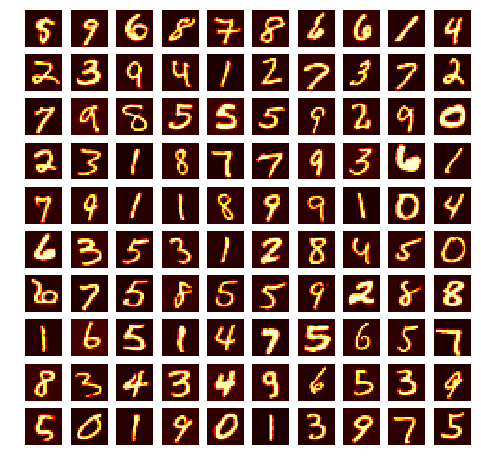

In [41]:
#visualizing the data 
import matplotlib.image as mpimg

fig, axis = plt.subplots(10,10, figsize=(8,8))

for i in range(10):
    for j in range(10):
        axis[i,j].imshow(X[np.random.randint(0,5001),:].reshape(20,20,order="F"),cmap="hot")
        #Adding order = "F" ensures that the image is upright
        axis[i,j].axis("off")
        

In [368]:
#Let's get the regularized logistic regression cost function from the previous assignment
from scipy.special import expit

def sigmoid(z):
    return expit(z)
    
    
def costfunctionreg(theta, X, y, lam):   
#     m = len(y)
#     hThetaX = sigmoid(np.dot(X,theta)) # 
#     J = -(np.dot(y,np.log(hThetaX)) + np.dot((1-y),np.log(1-hThetaX)) + (1/2 * lam * np.sum(np.square(theta))) )/m
#     return J

    m = y.shape[0]
    
    hThetaX = sigmoid(np.dot(X,theta))
    hThetaX = hThetaX.reshape(hThetaX.shape[0],1)

    #error = -(np.dot(y.T, np.log(hThetaX)) + np.dot((1-y).T, np.log(1-hThetaX)))
    error = (-y * np.log(hThetaX)) - ((1-y)*np.log(1-hThetaX))

    cost = 1/m * sum(error)
    #error = [-np.dot(y,np.log(hThetaX)) - np.dot(1-y,np.log(1-hThetaX))]
    #cost = error/m
    theta_squared_summed = np.sum(np.square(theta[1:]))
    
    J = cost + lam/(2*m) * theta_squared_summed
#     print("hthetaX", hThetaX)
#     print("hThetaX shape",hThetaX.shape)
#     print("cost",cost)
#     print("theta_squared_summed",theta_squared_summed)
#     print("error",error)
#     print("error shape",error.shape)
#     print("J",J)   
    
    return J
    
def gradientdescentreg(theta, X, y, lam):
    m = y.shape[0]
    hThetaX = sigmoid(np.dot(X,theta))

    new_theta = np.insert(theta[1:],0,0).reshape(theta.shape[0],1)

    
    grad = (np.dot(X.T, hThetaX-y) + lam*new_theta)/m
    #grad = grad.reshape(grad.shape[0],1)
#     print("Inside grad descent")
#     print("hThetaX.shape",hThetaX.shape)
#     print("new_theta shape",new_theta.shape)
#     print("Grad shape", grad.shape)
    return grad


In [369]:
theta_t = np.array([-2,-1,1,2]).reshape(4,1)
X_t =np.array([np.linspace(0.1,1.5,15)]).reshape(3,5).T
X_t = np.hstack((np.ones((5,1)), X_t))
y_t = np.array([1,0,1,0,1]).reshape(5,1)
lam =3
J = costfunctionreg(theta_t,X_t, y_t, lam)
#print(J)
grad = gradientdescentreg(theta_t, X_t, y_t, lam)
print(grad)

[[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]]


In [370]:
def gradientdescent_onevsall(X, y, theta, alpha, num_iters, lam):
    # we will update the value of theta and store the cost function history
    J_history = []
    for i in range(num_iters):
        cost = costfunctionreg(theta, X, y, lam)
        grad = gradientdescentreg(theta, X, y, lam)
        theta = theta - (alpha*grad)
        J_history.append(cost)
    return theta, J_history

In [360]:
#Implement One vs all
#In order to do this we will have to train classifiers for every class label
#our output should be theta parameter for every class, therefore the theta matrix will have num_label rows....
#...where num_label is the number of classes and it should have n+1 columns that is 1 for every feature plus X0

#How do we achieve this? 
#Run a loop num_label times
    #for each run manipulate y = {0,1}
    #when y == i then 1 else 0
    #call gradientdescent_onevsall
    #get theta parameters for the class i 
    #add these parameters to all_theta by using extend 
#once out of the loop, reshape all_theta

def OnevsAll(X, y, num_labels, lam):
    all_theta = []
    all_J = []
    m = X.shape[0] # number of training samples
    n = X.shape[1] # number of features
    initial_theta = np.zeros((n+1,1)) # (401,1) matrix
    
    #add_intercept terms
    X = np.hstack((np.ones((m,1)),X)) # (5000, 401)
    for i in range(num_labels):
        new_theta, J = gradientdescent_onevsall(X, np.where(y==i,1,0), initial_theta,1, 300, lam)
        all_theta.extend(new_theta)
        all_J.extend(J)
    
    return np.array(all_theta).reshape(num_labels,n+1), all_J

In [371]:
lam = 1
all_theta,all_J = OnevsAll(X, y, 10, lam)


Text(0.5,1,'Cost function using Gradient Descent')

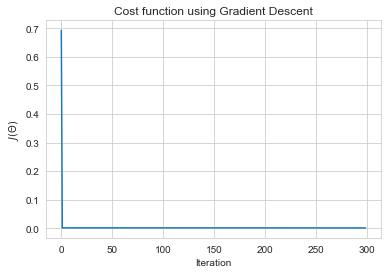

In [372]:
plt.plot(all_J[0:300])
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")


In [373]:
def predict_onevsall(all_theta,X):
    
    #X does not have the X0 column so let's add that intercep
    #This would be a column of ones as long as the number of rows in X
    rows = X.shape[0]
    X_new = np.hstack((np.ones((rows,1)),X))
    prediction = np.dot(X_new,all_theta.T)
    return np.argmax(prediction, axis = 1)+1
    

In [374]:
pred = predict_onevsall(all_theta, X)
print("Training Set Accuracy:",sum(pred[:,np.newaxis]==y)[0]/5000*100,"%")

Training Set Accuracy: 1.18 %


# Part 2) Neural Networks

In [243]:
#Let's start off by getting the accuracy on the optimal parameters

opt_theta = loadmat('ex3weights.mat')
Theta1 = opt_theta['Theta1']
Theta2 = opt_theta['Theta2']
print("Theta 1 shape:", Theta1.shape)
print("Theta 2 shape:", Theta2.shape)

Theta 1 shape: (25, 401)
Theta 2 shape: (10, 26)


In [244]:
print(X.shape)

(5000, 400)


In [257]:
def predict_nn(Theta1, Theta2,X):
    m = X.shape[0] #number of rows
    X_new = np.hstack((np.ones((m,1)),X))
    a1 = sigmoid(np.dot(X_new,Theta1.T))
    a1 = np.hstack((np.ones((m,1)),a1))
    a2 = sigmoid(np.dot(a1,Theta2.T)) #output layer
    print(np.min(a2), np.max(a2))
    return np.argmax(a2, axis = 1)+1

In [259]:
pred2 = predict_nn(Theta1, Theta2, X)
print(pred2)
print("Training Set Accuracy:",sum(pred2[:,np.newaxis]==y)[0]/5000*100,"%")

2.588105091914558e-07 0.9996011513253986
[10 10 10 ...  9  9  9]
Training Set Accuracy: 97.52 %
